<a href="https://colab.research.google.com/github/chisomrutherford/malaria-diagnosis-with-cnn/blob/main/Malaria_Diagnosis_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagnosis of Malaria by Analyzing Blood Smears Captured by a Microscope Using Convolutional Neural Network

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown


In [ ]:
import zipfile

with zipfile.ZipFile ('cell-images-for-detecting-malaria.zip', 'r') as zip_ref:
  zip_ref.extractall ('malaria_dataset')

# Exploratory Data Analysis
This section loads the data and shows examples of the images in the dataset

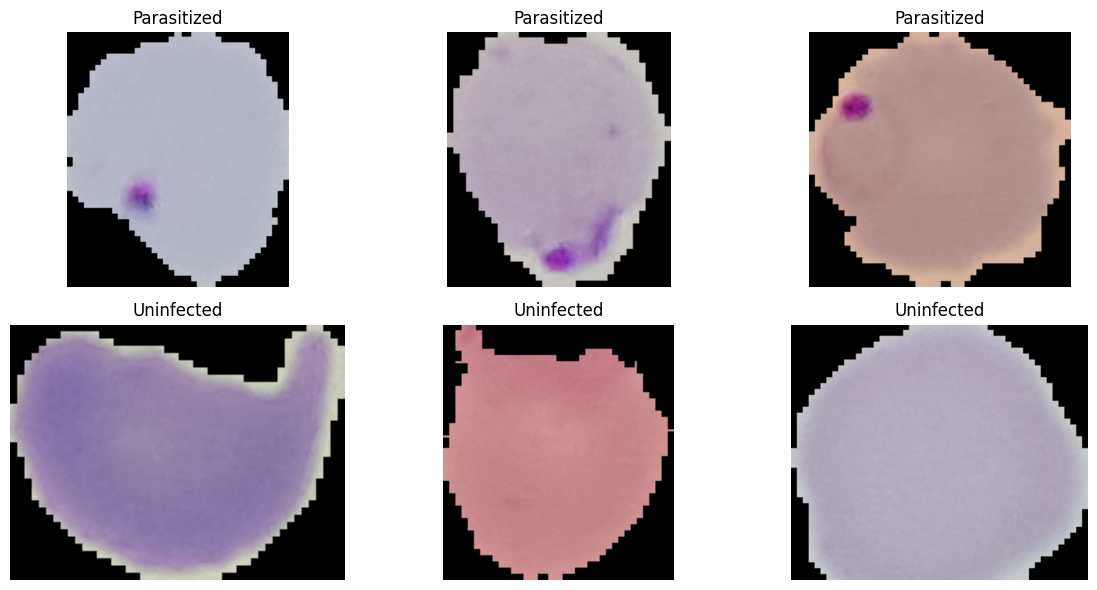

In [ ]:
#Import dependencies
import os
import cv2
import random
import matplotlib.pyplot as plt

#Load the data
data_dir = 'malaria_dataset/cell_images/cell_images'
categories = ['Parasitized', 'Uninfected']

#This function displays the images in the dataset
def show_random_images (data_dir, categories, n= 3):
  plt.figure (figsize = (12, 6))
  for i, cat in enumerate (categories):
    path = os.path.join (data_dir, cat)
    images = os.listdir (path)

    for j in range(n):
      img_path = os.path.join(path, random.choice(images))
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.subplot(len(categories), n, i*n+j+1)
      plt.imshow(img)
      plt.title(cat)
      plt.axis('off')
  plt.tight_layout()
  plt.show()

show_random_images(data_dir, categories)


# Data Preprocessing

In [ ]:
#Import necessary dependencies and also perform data augmentation.

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = 128

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2

)
print ('Data augmentation complete. 20% of the dataset for validation.')

Data augmentation complete. 20% of the dataset for validation.


In [ ]:
#Create a data generator for the validation set

train_generator= train_datagen.flow_from_directory (
    data_dir,
    target_size = (img_size, img_size),
    batch_size =32,
    class_mode = 'binary',
    subset = 'training',
    shuffle = True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


# Model Development

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)

print ('Congratulation! Training is complete')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 146s 199ms/step - accuracy: 0.6615 - loss: 9.7983 - precision: 0.6562 - recall: 0.6678 - val_accuracy: 0.8176 - val_loss: 5.3203 - val_precision: 0.8143 - val_recall: 0.8229 - learning_rate: 1.0000e-04
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 134s 195ms/step - accuracy: 0.8671 - loss: 4.4371 - precision: 0.8417 - recall: 0.9030 - val_accuracy: 0.8866 - val_loss: 2.6365 - val_precision: 0.8301 - val_recall: 0.9721 - learning_rate: 1.0000e-04
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 132s 191ms/step - accuracy: 0.8998 - loss: 2.2783 - precision: 0.8705 - recall: 0.9385 - val_accuracy: 0.9016 - val_loss: 1.4912 - val_precision: 0.8485 - val_recall: 0.9779 - learning_rate: 1.0000e-04
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 134s 195ms/step - accuracy: 0.9166 - loss: 1.3132 - precision: 0.8896 - recall: 0.9527 - val_accuracy: 0.9158 - val_loss: 0.9371 - val_precision: 0.8962 - val_recall: 0.9405 - learning_rate: 1.0000e-04
Epoch 5/30
689/689 ━━━━━━━━━━━━━

# Model Evaluation

173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.9189 - loss: 0.2372 - precision: 0.3965 - recall: 0.4784

True Validation Accuracy: 93.39%
Precision: 91.90%
Recall: 95.17%
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step


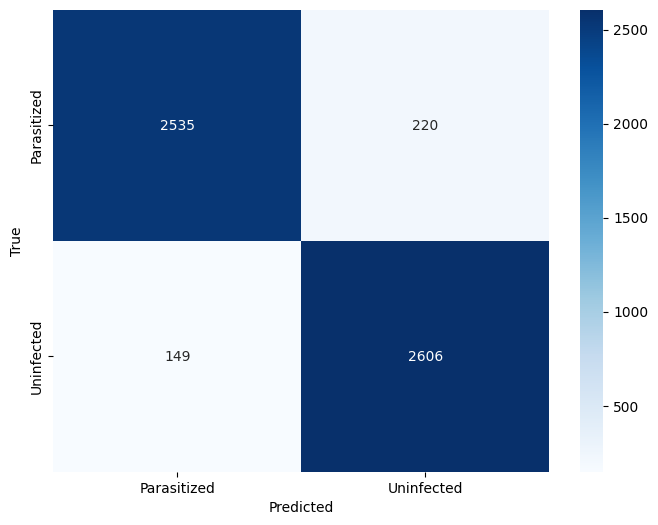

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

val_loss, val_acc, val_precision, val_recall = model.evaluate(validation_generator)
print(f"\nTrue Validation Accuracy: {val_acc:.2%}")
print(f"Precision: {val_precision:.2%}")
print(f"Recall: {val_recall:.2%}")

# Proper confusion matrix generation
y_pred = model.predict(validation_generator)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(validation_generator.classes, y_pred_binary)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save Model on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/malaria_model.keras'
model.save(model_save_path)

print("Model saved to Google Drive Successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive Successfully!
